## Advanced Data Preparation Using Custom Transformers in Scikit-Learn
- https://towardsdatascience.com/advanced-data-preparation-using-custom-transformers-in-scikit-learn-5e58d2713ac5

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right"> Initial upload: 2023.8. 8</div>
<div style="text-align: right"> Last update: 2023. 8. 8</div>

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

사이킷런에서 트랜스포머를 만드는 방법 2가지
- FunctionTransformer
- 커스텀 트랜스포머를 scratch로 구현

### Transformers: The best way to preprocess data in scikit-learn

사이킷런에서 Transformer는 fit(), transform() 메서드를 가진다.

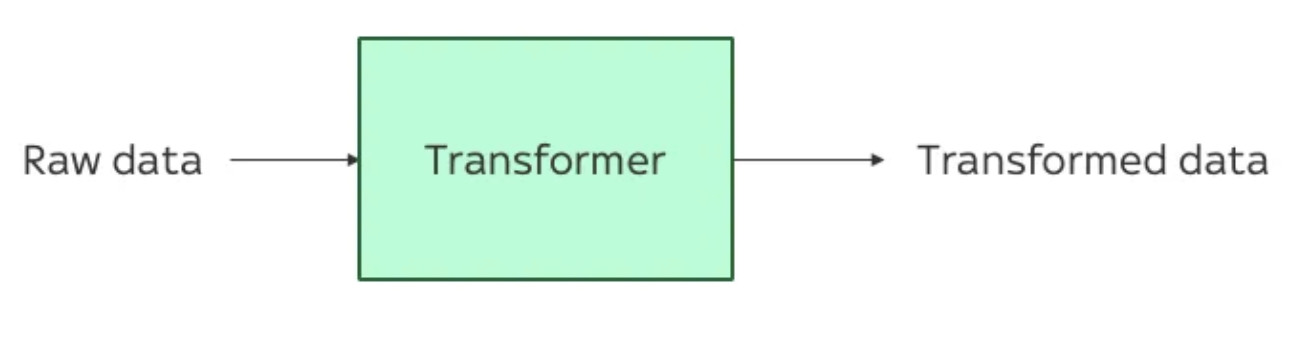

사이킷런에는 다양한 빌트인 transformer가 존재 
- sklearn.impute.SimpleImputer
- sklearn.preprocessing.MinMaxScaler
- sklearn.preprocessing.OneHotEncoder 등

사이킷런의 sklearn.pipeline.Pipeline을 사용하면 트랜스포머 체인을 형성해서 멀티스텝 data preparation, fe workflow를 형성할 수 있다.

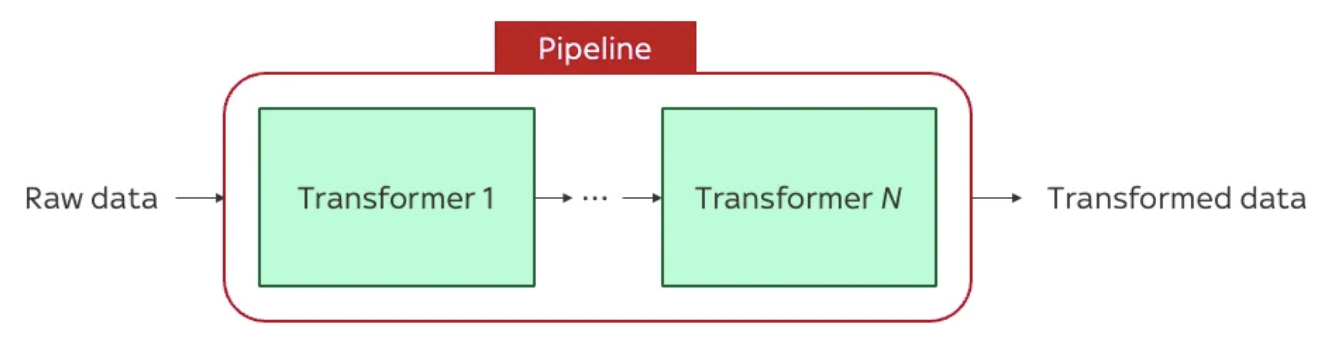

### Data

In [2]:
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Load data and split into training and testing sets
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
X.drop(['boat', 'body', 'home.dest'], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
X_train.head()


,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
413,2.0,"Gale, Mr. Harry",male,38.0,1.0,0.0,28664,21.0000,None,S
1171,3.0,"Sage, Master. William Henry",male,14.5,8.0,2.0,CA. 2343,69.5500,None,S
547,2.0,"Richard, Mr. Emile",male,23.0,0.0,0.0,SC/PARIS 2133,15.0458,None,C
441,2.0,"Hewlett, Mrs. (Mary D Kingcome)",female,55.0,0.0,0.0,248706,16.0000,None,S
436,2.0,"Hart, Mrs. Benjamin (Esther Ada Bloomfield)",female,45.0,1.0,1.0,F.C.C. 13529,26.2500,None,S


### 1. FunctionTransformer

FunctionTransformer 클래스를 사용하면 간단하게 커스텀 트랜스포머를 만들 수 있다.  
입력 데이터 X를 인자로 받고 transformed된 데이터를 리턴하는 함수를 구현 한 후 FunctionTransformer로 래핑하면 된다.

In [3]:
from sklearn.preprocessing import FunctionTransformer

def extract_title(X):
    """Extract the title from each passenger's `name`."""
    X['title'] = X['name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    return X

extract_title_transformer = FunctionTransformer(extract_title)
print(type(extract_title_transformer))

<class 'sklearn.preprocessing._function_transformer.FunctionTransformer'>


In [4]:
from sklearn.pipeline import Pipeline

preprocessor = Pipeline(steps=[
  ('extract_title', extract_title_transformer),
  # ... any other transformers we want to include, e.g. SimpleImputer or MinMaxScaler
])

X_train_transformed = preprocessor.fit_transform(X_train)
X_train_transformed

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,title
413,2.0,"Gale, Mr. Harry",male,38.0,1.0,0.0,28664,21.0000,None,S,Mr
1171,3.0,"Sage, Master. William Henry",male,14.5,8.0,2.0,CA. 2343,69.5500,None,S,Master
547,2.0,"Richard, Mr. Emile",male,23.0,0.0,0.0,SC/PARIS 2133,15.0458,None,C,Mr
441,2.0,"Hewlett, Mrs. (Mary D Kingcome)",female,55.0,0.0,0.0,248706,16.0000,None,S,Mrs
436,2.0,"Hart, Mrs. Benjamin (Esther Ada Bloomfield)",female,45.0,1.0,1.0,F.C.C. 13529,26.2500,None,S,Mrs
...,...,...,...,...,...,...,...,...,...,...,...
406,2.0,"Faunthorpe, Mr. Harry",male,40.0,1.0,0.0,2926,26.0000,None,S,Mr
894,3.0,"Johnson, Master. Harold Theodor",male,4.0,1.0,1.0,347742,11.1333,None,S,Master
97,1.0,"Douglas, Mrs. Frederick Charles (Mary Helene B...",female,27.0,1.0,1.0,PC 17558,247.5208,B58 B60,C,Mrs
259,1.0,"Seward, Mr. Frederic Kimber",male,34.0,0.0,0.0,113794,26.5500,None,S,Mr


더 복잡한 형태로 구현해보자.

In [5]:
# def extract_title(X):
#     """Extract the title from each passenger's `name`."""
#     X['title'] = X['name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]

# def is_upper_class(X, upper_class_titles):
#     """If the passenger's title is in the list of `upper_class_titles`, return 1, else 0."""
#     X['upper_class'] = X['title'].apply(lambda x: 1 if x in upper_class_titles else 0)
#     return X

# preprocessor = Pipeline(steps=[
#   ('extract_title', FunctionTransformer(extract_title)),
#   ('is_upper_class', FunctionTransformer(is_upper_class,
#                       kw_args={'upper_class_titles':['Dr', 'Col', 'Major', 'Lady', 'Rev', 'Sir', 'Capt']})),
#     # ... any other transformers we want to include, e.g. SimpleImputer or MinMaxScaler
# ])

# X_train_transformed = preprocessor.fit_transform(X_train)
# X_train_transformed

#### 1.1 The limitations of FunctionTransformer: Stateful transformations

FunctionTransformer는 stateless transformation만 적용가능하다.

### 2. Create a custom Transformer from scratch

In [6]:
from sklearn.base import TransformerMixin

class ExtractTitle(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X['title'] = X['name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
        return X

preprocessor = Pipeline(steps=[
    ('extract_title', ExtractTitle()),
])

X_train_transformed = preprocessor.fit_transform(X_train)
X_train_transformed.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,title
413,2.0,"Gale, Mr. Harry",male,38.0,1.0,0.0,28664,21.0000,None,S,Mr
1171,3.0,"Sage, Master. William Henry",male,14.5,8.0,2.0,CA. 2343,69.5500,None,S,Master
547,2.0,"Richard, Mr. Emile",male,23.0,0.0,0.0,SC/PARIS 2133,15.0458,None,C,Mr
441,2.0,"Hewlett, Mrs. (Mary D Kingcome)",female,55.0,0.0,0.0,248706,16.0000,None,S,Mrs
436,2.0,"Hart, Mrs. Benjamin (Esther Ada Bloomfield)",female,45.0,1.0,1.0,F.C.C. 13529,26.2500,None,S,Mrs


In [7]:
class IsUpperClass(TransformerMixin):
    def __init__(self, upper_class_titles):
        self.upper_class_titles = upper_class_titles        
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X['upper_class'] = X['title'].apply(lambda x: 1 if x in self.upper_class_titles else 0)
        return X

preprocessor = Pipeline(steps=[
    ('IsUpperClass', IsUpperClass(upper_class_titles=['Dr', 'Col', 'Major', 'Lady', 'Rev', 'Sir', 'Capt'])),
])

X_train_transformed = preprocessor.fit_transform(X_train)
X_train_transformed.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,title,upper_class
413,2.0,"Gale, Mr. Harry",male,38.0,1.0,0.0,28664,21.0000,None,S,Mr,0
1171,3.0,"Sage, Master. William Henry",male,14.5,8.0,2.0,CA. 2343,69.5500,None,S,Master,0
547,2.0,"Richard, Mr. Emile",male,23.0,0.0,0.0,SC/PARIS 2133,15.0458,None,C,Mr,0
441,2.0,"Hewlett, Mrs. (Mary D Kingcome)",female,55.0,0.0,0.0,248706,16.0000,None,S,Mrs,0
436,2.0,"Hart, Mrs. Benjamin (Esther Ada Bloomfield)",female,45.0,1.0,1.0,F.C.C. 13529,26.2500,None,S,Mrs,0
